# Emotional numbing in PTSD a look into a paradox

PTSD symptoms include (not only) symptoms of hyper arousal, anger, nightmares, problems with emotion regulation and... emotional numbing. </br>
While most symptoms point to over expression of emotions, emotional numbing states that there is low emotionality.

In a not really direct way, here, we will continue to explore the idea we proposed in the SIA paper.</br>
https://www.nature.com/articles/s41386-022-01405-2</br>
Mainly, reduced response to low valance/arousing stimuli and high response to higher valance stimuli.

In this experiment we will explore this by asking people with or without diagnosis of PTSD to rate pictures from known datasets (IAPS/NAPS).</br> 
Using the dataset reported valence rating as the X axis and participants rating as the y-axis, we will fit a 5 parameter logistic regression to the curve of participants and compare the parameters between the groups.

The formula we will use for the 5PL regression:
$$
y = d + \frac{a-d}{[1+(\frac{x}{c})^b]^g}
$$
a theoretical response at min</br>
b slope factor</br>
c mid range </br>
d theoretical response at max</br>
g asymmetrical factor</br>

Our main hypothesis is regarding b (Lower values of b point to a linear relation).</br>
We hypothesize that the PTSD group will show a larger b  compared with control.</br>
Secondary hypothesis include:</br>
1. b will be modulated by emotional numbing (PCL5)</br>
2. d will be modulated by depression/anhedonia score (PCL5/BDI)

In [1]:
import pandas as pd
import numpy as np

import pymc as pm
import arviz as az

import pymc.sampling_jax as jx
import jax

import matplotlib.pyplot as ply
import seaborn as sns

/gpfs/ysm/project/levy_ifat/nk549/conda_envs/numbing/lib/python3.9/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Subject creation function

In [2]:
def add_sub(trials = 100, min_r = 0, max_r = 4, noise = .1, 
            slope=10, a1 = 1, a2 = 20, c_mu = 2, d1 = 10, d2 = 10, g_mu = 1,
            axis = False):
    
    x = np.arange(min_r, max_r, max_r/trials)
    a = np.random.beta(a1, a2, 1)[0] # close to 0 but not 0.
    b = np.random.normal(slope, 2, 1)[0] # this is where the magic happens
    c = np.random.normal(c_mu, .5, 1)[0] # kind of average
    d = np.random.beta(d1, d2, 1)[0] # close to 0.5
    g = np.random.normal(g_mu, .2, 1)[0] # almost symetrical
    
    if b<.5:
        b=.5
    
    # the 5PL formula
    y = d + (a-d)/(1+(x/c)**b)**g + np.random.normal(0, noise, trials)
    
    # replace negative values with 0 (you cannot rate lower than 0)
    y = [0 if i < 0 else i for i in y]   

    df = pd.DataFrame({'x': x, 'y': y, 'b':b})
    if axis:
        return(x)
    return(df)

## PYMC models

In the first stage 2 models will be tested.

Model 1: no hyper priors.

Model 2: with hyper priors

### Model1 No hyper priors

In [7]:
def pl5_no_hyper(df_all, idx, n_subs1, n_subs2=0):
    
    if n_subs2 == 0:
        n_subs2 = n_subs1

    with pm.Model() as five_PL:
        
        # priors
        a = pm.Beta('a',     1, 20, shape = n_subs1+n_subs2)
        b = pm.TruncatedNormal('b',   4,  3, lower = 1, shape = n_subs1+n_subs2)
        c = pm.TruncatedNormal('c', 3, .1, lower=1, shape = n_subs1+n_subs2)
        d = pm.Beta('d',    10, 10, shape = n_subs1+n_subs2)
        g = pm.Normal('g', 1.1, .2, shape = n_subs1+n_subs2)


        eps = pm.Exponential('eps', 1)

        # model prediction using the 5PL regression    
        y_hat = d[idx] + (a[idx]-d[idx])/(1+(df_all['x'].values/c[idx])**b[idx])**g[idx]

        # Likelihood (sampling distribution) of observations
        rating = pm.Normal('rating',y_hat, eps, observed=df_all.y)

        trace = jx.sample_numpyro_nuts(2000, target_accept=0.95)

    return trace

### Model2 With hyper Priors

In [10]:
def pl5_hyper(df_all, idx, group_sub_id):
    

    with pm.Model() as five_PL_hyper:

        # hyper priors
        mu_b = pm.Normal('mu_b', 4,    3, shape = 2)
        mu_c = pm.Normal('mu_c', 3,  1, shape = 2)
        mu_g = pm.TruncatedNormal('mu_g', 1.1, .2, lower = .6, shape = 2)

        a1 = pm.TruncatedNormal('a1', 1, .3, lower = 0.1, shape = 2)
        a2 = pm.Normal('a2', 20, 4, shape = 2)

        d1 = pm.TruncatedNormal('d1', 12, 2, lower = 0.1, shape = 2)
        d2 = pm.TruncatedNormal('d2', 8,  2, lower = 0.1, shape = 2)

        # priors
        a = pm.Beta('a',   a1[group_sub_id[:, 0]],    a2[group_sub_id[:, 0]])
        b = pm.TruncatedNormal('b', mu_b[group_sub_id[:, 0]],   2, lower=1)
        c = pm.TruncatedNormal('c', mu_c[group_sub_id[:, 0]],   1, lower=1)
        d = pm.Beta('d',   d1[group_sub_id[:, 0]],    d2[group_sub_id[:, 0]])
        g = pm.Normal('g', mu_g[group_sub_id[:, 0]], .15)

        y_hat = d[idx] + (a[idx]-d[idx])/(1+(df_all['x'].values/c[idx])**b[idx])**g[idx]

        eps = pm.Exponential('eps', 5, shape = 2)
        # Likelihood (sampling distribution) of observations
        rating = pm.Normal('rating',y_hat, eps[df_all['group_id'].values], observed=df_all.y)


        trace = pm.sample(tune = 3000, draws = 1000, target_accept=0.95)
        
    return trace

## Test 1: Equal groups small noise

<AxesSubplot:xlabel='x', ylabel='y'>

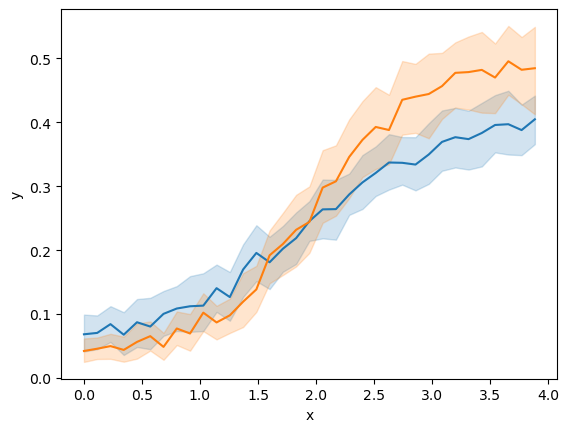

In [5]:
n_subs = 20
cont_df = pd.DataFrame()
ptsd_df = pd.DataFrame()

for i in range(n_subs):
    
    temp_c = add_sub(noise = .05, slope = 3, trials = 35)
    temp_c['sub'] = i
    cont_df = pd.concat([cont_df, temp_c])
    
    temp_p = add_sub(noise = .05, slope = 6, trials = 35)
    temp_p['sub'] = i
    ptsd_df = pd.concat([ptsd_df, temp_p])
    
sub_idxC = list(cont_df['sub'])
sub_idxP = list(ptsd_df['sub'])


sns.lineplot(x='x',y='y',data=cont_df)
sns.lineplot(x='x',y='y',data=ptsd_df)

In [6]:
df_all = pd.concat([cont_df, ptsd_df], keys=['control', 'ptsd'], names=['group']).reset_index()
df_all['group_id'] = df_all['group'].astype('category').cat.codes
df_all['sub_id'] = df_all['sub'] + df_all['group_id'] * n_subs
group_sub_id = np.unique(df_all[['group_id', 'sub_id']].values, axis=0)
idx = df_all['sub_id'].values

In [8]:
trace_nh = pl5_no_hyper(df_all, idx, n_subs)

Compiling...
Compilation time =  0:00:04.871130
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:01:50.945617
Transforming variables...
Transformation time =  0:00:00.246787
Computing Log Likelihood...
Log Likelihood time =  0:00:02.093764


In [11]:
trace_hp = pl5_hyper(df_all, idx, group_sub_id)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b, mu_c, mu_g, a1, a2, d1, d2, a, b, c, d, g, eps]
INFO:pymc:NUTS: [mu_b, mu_c, mu_g, a1, a2, d1, d2, a, b, c, d, g, eps]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 388 seconds.
INFO:pymc:Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 388 seconds.


array([[<AxesSubplot:title={'center':'g'}>,
        <AxesSubplot:title={'center':'g'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'d'}>,
        <AxesSubplot:title={'center':'d'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

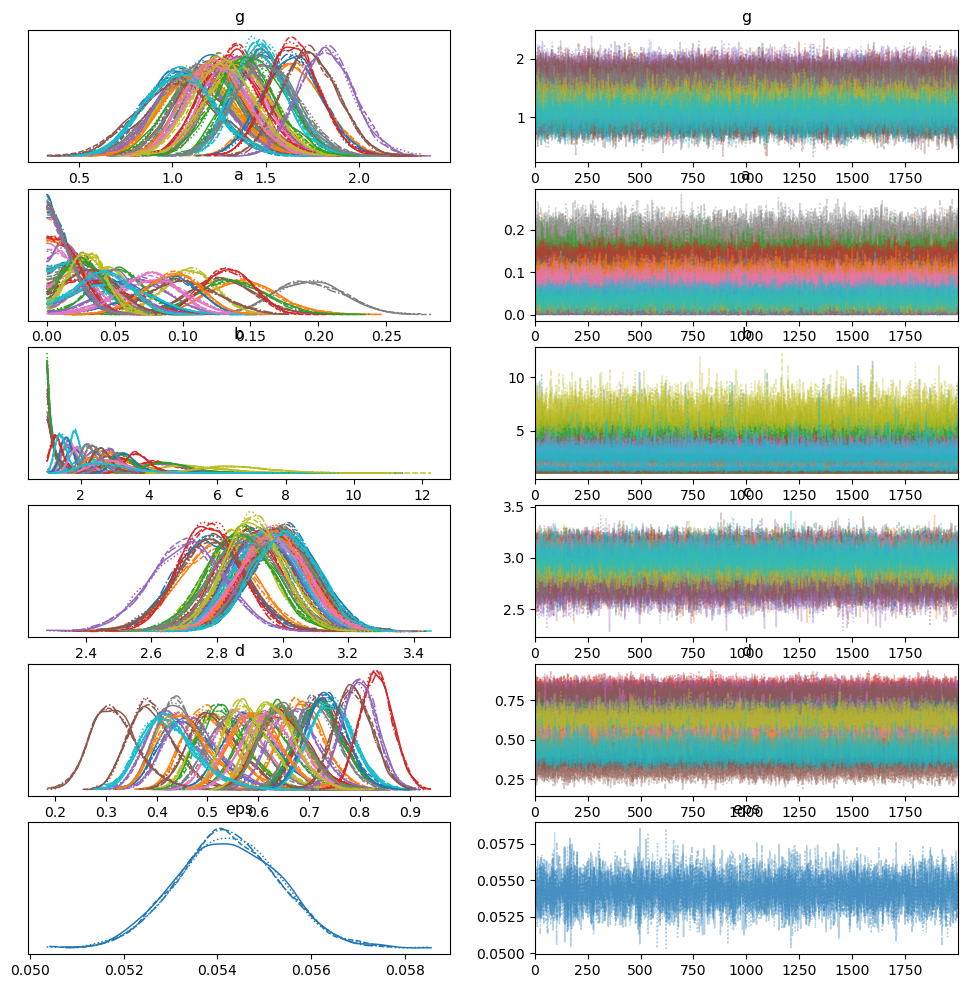

In [12]:
az.plot_trace(trace_nh)

array([[<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'mu_c'}>,
        <AxesSubplot:title={'center':'mu_c'}>],
       [<AxesSubplot:title={'center':'a2'}>,
        <AxesSubplot:title={'center':'a2'}>],
       [<AxesSubplot:title={'center':'g'}>,
        <AxesSubplot:title={'center':'g'}>],
       [<AxesSubplot:title={'center':'mu_g'}>,
        <AxesSubplot:title={'center':'mu_g'}>],
       [<AxesSubplot:title={'center':'a1'}>,
        <AxesSubplot:title={'center':'a1'}>],
       [<AxesSubplot:title={'center':'d1'}>,
        <AxesSubplot:title={'center':'d1'}>],
       [<AxesSubplot:title={'center':'d2'}>,
        <AxesSubplot:title={'center':'d2'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'

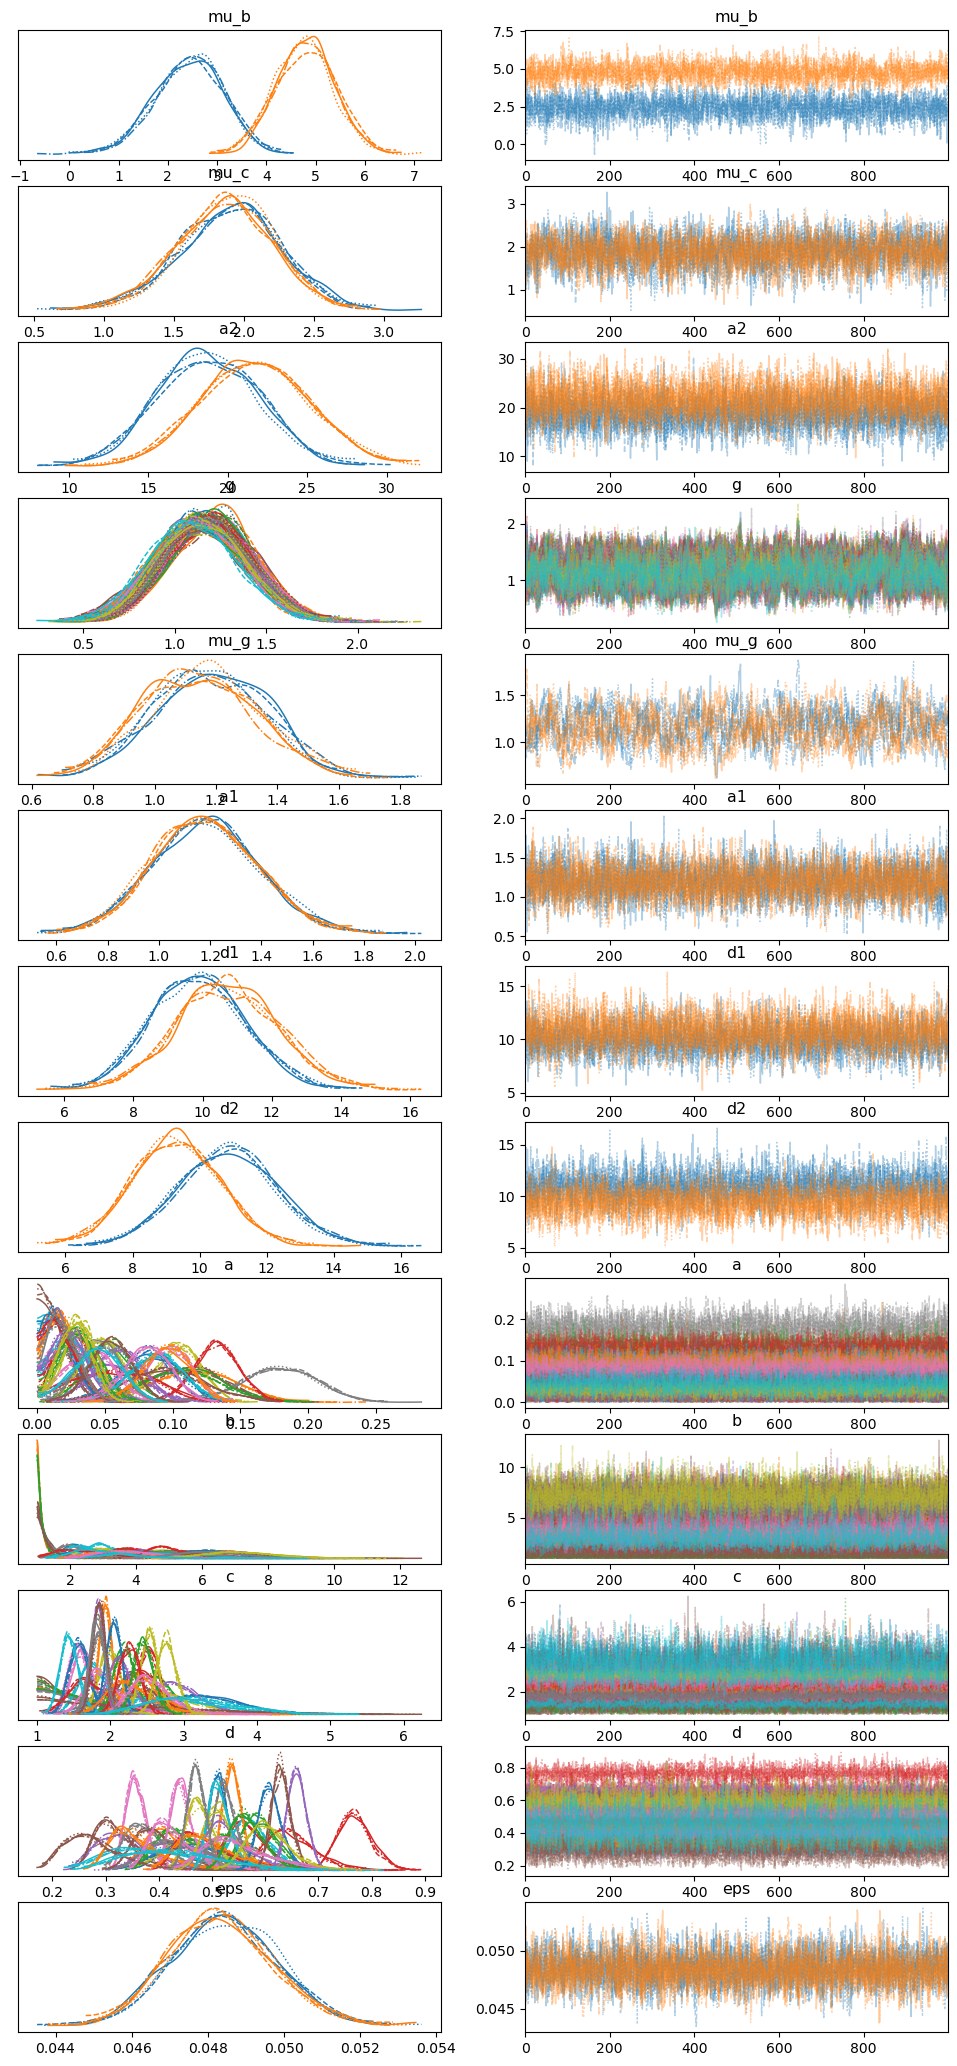

In [13]:
az.plot_trace(trace_hp)

In [14]:
comp = az.compare({'model1': trace_nh, 'model2': trace_hp}, ic='loo')
comp

/gpfs/ysm/project/levy_ifat/nk549/conda_envs/numbing/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/gpfs/ysm/project/levy_ifat/nk549/conda_envs/numbing/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank          loo       p_loo       d_loo  weight         se  \
model2     0  2180.281501  133.412910    0.000000     1.0  27.739927   
model1     1  2039.343444  101.177427  140.938056     0.0  27.865223   

              dse  warning loo_scale  
model2   0.000000     True       log  
model1  16.750544     True       log

<AxesSubplot:xlabel='Log'>

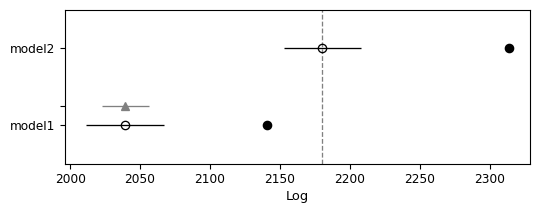

In [15]:
az.plot_compare(comp)

The model with hyper priors out preform the model without hyper priors

However, can the model handle uneven number of participants?

## Test 2: uneven groups

<AxesSubplot:xlabel='x', ylabel='y'>

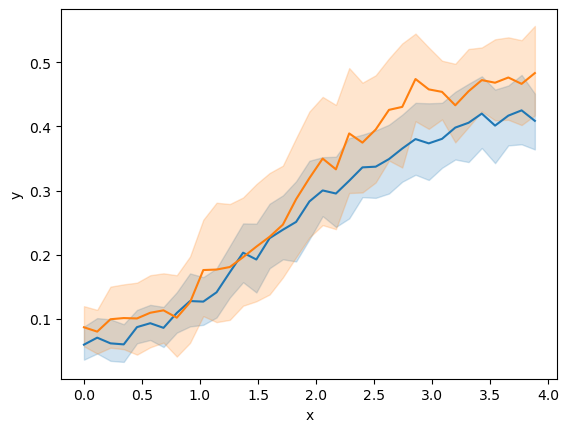

In [16]:
n_subs = 20
cont_df = pd.DataFrame()
ptsd_df = pd.DataFrame()

for i in range(n_subs):
    
    temp_c = add_sub(noise = .05, slope = 3, trials = 35)
    temp_c['sub'] = i
    cont_df = pd.concat([cont_df, temp_c])
    if i<10:
        temp_p = add_sub(noise = .05, slope = 6, trials = 35)
        temp_p['sub'] = i
        ptsd_df = pd.concat([ptsd_df, temp_p])
    
sub_idxC = list(cont_df['sub'])
sub_idxP = list(ptsd_df['sub'])


sns.lineplot(x='x',y='y',data=cont_df)
sns.lineplot(x='x',y='y',data=ptsd_df)

In [17]:
df_all = pd.concat([cont_df, ptsd_df], keys=['control', 'ptsd'], names=['group']).reset_index()
df_all['group_id'] = df_all['group'].astype('category').cat.codes
df_all['sub_id'] = df_all['sub'] + df_all['group_id'] * n_subs
group_sub_id = np.unique(df_all[['group_id', 'sub_id']].values, axis=0)
idx = df_all['sub_id'].values

In [18]:
trace_nh_ue = pl5_no_hyper(df_all, idx, n_subs)
trace_hp_ue = pl5_hyper(df_all, idx, group_sub_id)

Compiling...
Compilation time =  0:00:04.482389
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:01:24.907249
Transforming variables...
Transformation time =  0:00:00.090063
Computing Log Likelihood...
Log Likelihood time =  0:00:01.662614


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b, mu_c, mu_g, a1, a2, d1, d2, a, b, c, d, g, eps]
INFO:pymc:NUTS: [mu_b, mu_c, mu_g, a1, a2, d1, d2, a, b, c, d, g, eps]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 327 seconds.
INFO:pymc:Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 327 seconds.


In [19]:
comp = az.compare({'model1': trace_nh_ue, 'model2': trace_hp_ue}, ic='loo')
comp

/gpfs/ysm/project/levy_ifat/nk549/conda_envs/numbing/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/gpfs/ysm/project/levy_ifat/nk549/conda_envs/numbing/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank          loo      p_loo       d_loo  weight         se       dse  \
model2     0  1676.579797  95.257245    0.000000     1.0  23.149690   0.00000   
model1     1  1537.918423  73.460785  138.661374     0.0  25.177846  17.05345   

        warning loo_scale  
model2     True       log  
model1     True       log

<AxesSubplot:ylabel='Count'>

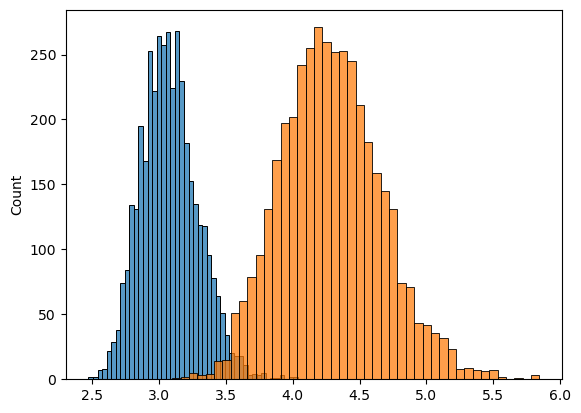

In [31]:
tr = trace_hp_ue.posterior.stack(draws=("chain", "draw"))

Control = np.mean(tr.b[:n_subs,:].values, axis = 0)
PTSD    = np.mean(tr.b[n_subs:,:].values, axis = 0)

sns.histplot(Control)
sns.histplot(PTSD)


The model is robust to uneven samples

## Does the model works for bigger samples with a bit more noise?

<AxesSubplot:xlabel='x', ylabel='y'>

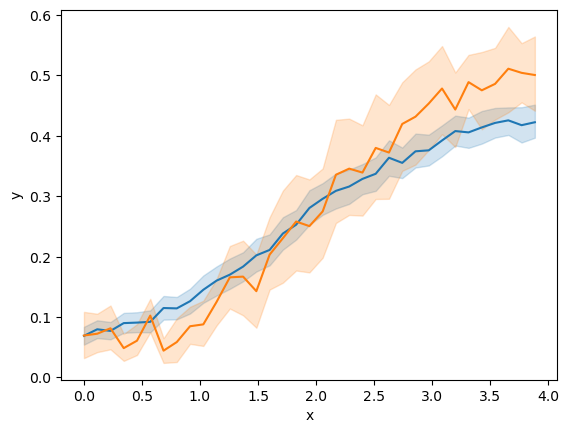

In [24]:
n_subs = 100
cont_df = pd.DataFrame()
ptsd_df = pd.DataFrame()

for i in range(n_subs):
    
    temp_c = add_sub(noise = .08, slope = 3, trials = 35)
    temp_c['sub'] = i
    cont_df = pd.concat([cont_df, temp_c])
    if i<20:
        temp_p = add_sub(noise = .08, slope = 6, trials = 35)
        temp_p['sub'] = i
        ptsd_df = pd.concat([ptsd_df, temp_p])
    
sub_idxC = list(cont_df['sub'])
sub_idxP = list(ptsd_df['sub'])


sns.lineplot(x='x',y='y',data=cont_df)
sns.lineplot(x='x',y='y',data=ptsd_df)

In [25]:
df_all = pd.concat([cont_df, ptsd_df], keys=['control', 'ptsd'], names=['group']).reset_index()
df_all['group_id'] = df_all['group'].astype('category').cat.codes
df_all['sub_id'] = df_all['sub'] + df_all['group_id'] * n_subs
group_sub_id = np.unique(df_all[['group_id', 'sub_id']].values, axis=0)
idx = df_all['sub_id'].values

In [26]:
trace_hp_max = pl5_hyper(df_all, idx, group_sub_id)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b, mu_c, mu_g, a1, a2, d1, d2, a, b, c, d, g, eps]
INFO:pymc:NUTS: [mu_b, mu_c, mu_g, a1, a2, d1, d2, a, b, c, d, g, eps]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 625 seconds.
INFO:pymc:Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 625 seconds.


array([[<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'mu_c'}>,
        <AxesSubplot:title={'center':'mu_c'}>],
       [<AxesSubplot:title={'center':'a2'}>,
        <AxesSubplot:title={'center':'a2'}>],
       [<AxesSubplot:title={'center':'g'}>,
        <AxesSubplot:title={'center':'g'}>],
       [<AxesSubplot:title={'center':'mu_g'}>,
        <AxesSubplot:title={'center':'mu_g'}>],
       [<AxesSubplot:title={'center':'a1'}>,
        <AxesSubplot:title={'center':'a1'}>],
       [<AxesSubplot:title={'center':'d1'}>,
        <AxesSubplot:title={'center':'d1'}>],
       [<AxesSubplot:title={'center':'d2'}>,
        <AxesSubplot:title={'center':'d2'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'

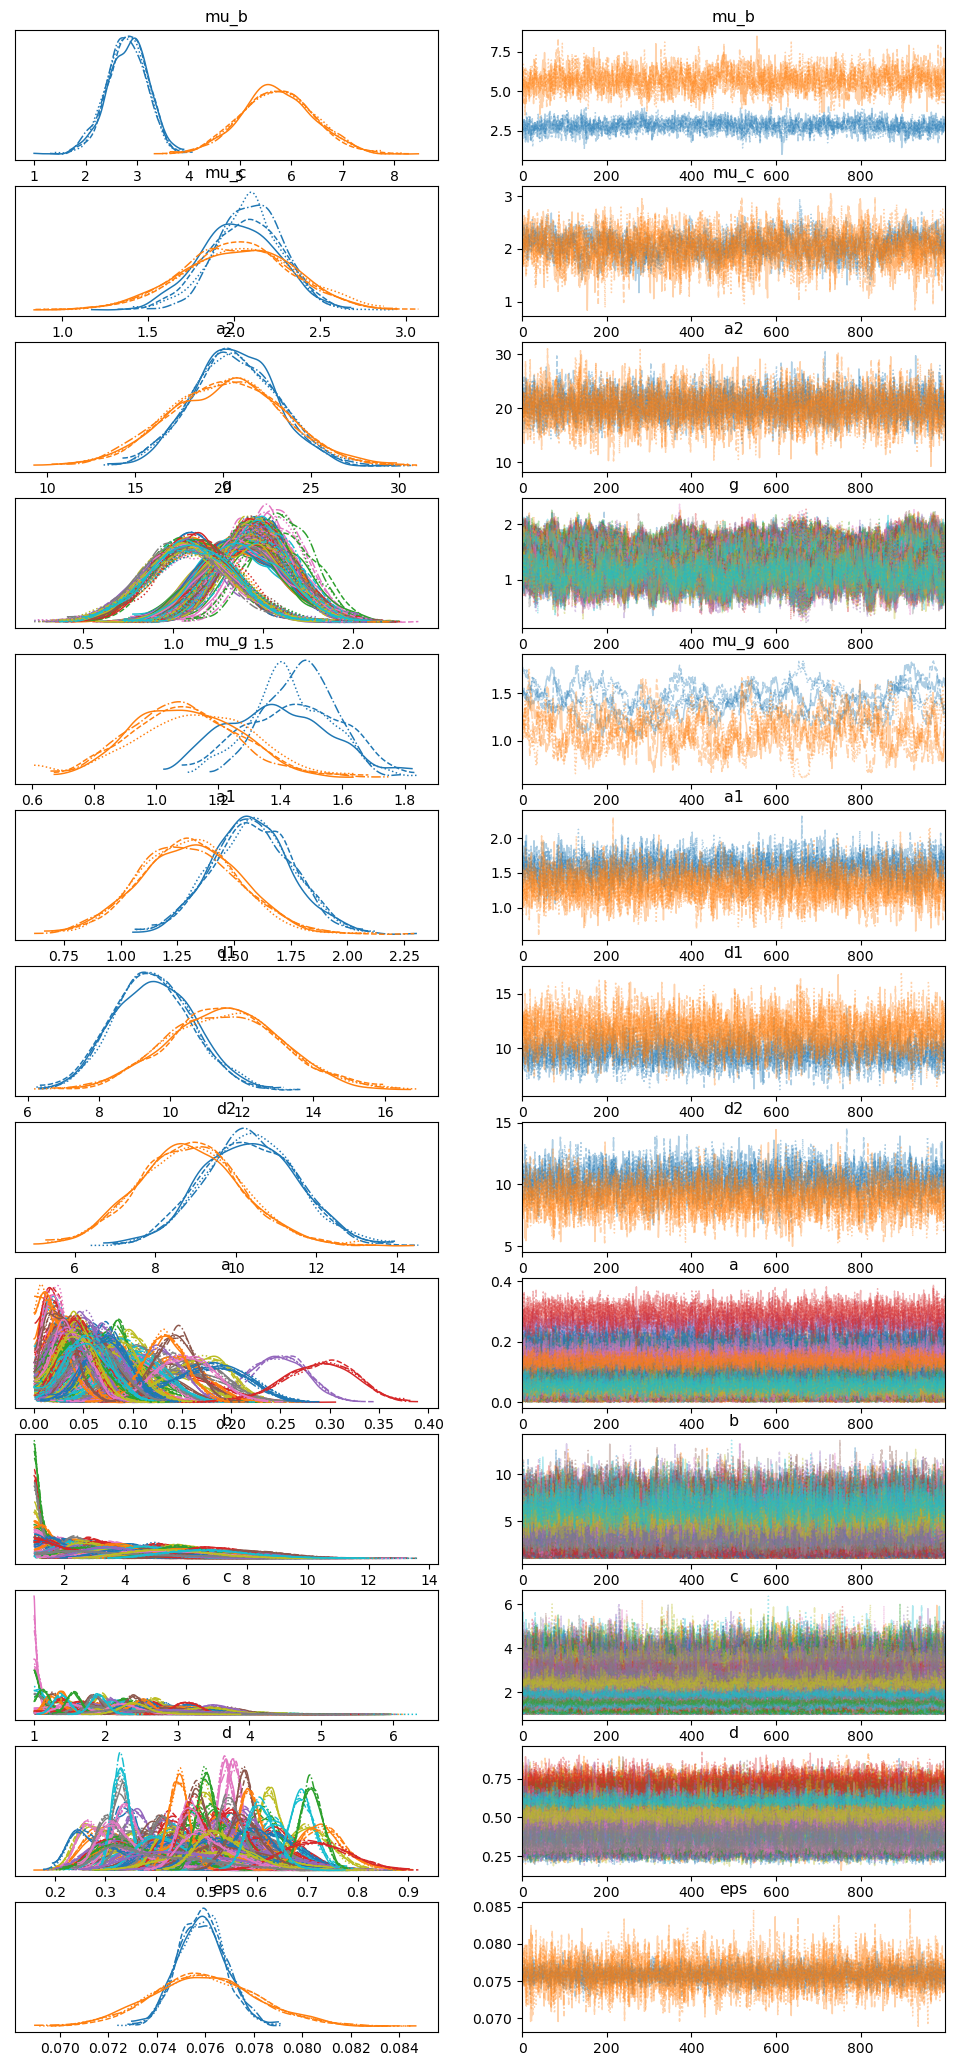

In [27]:
az.plot_trace(trace_hp_max)

# Test 1 group almost linear

<AxesSubplot:xlabel='x', ylabel='y'>

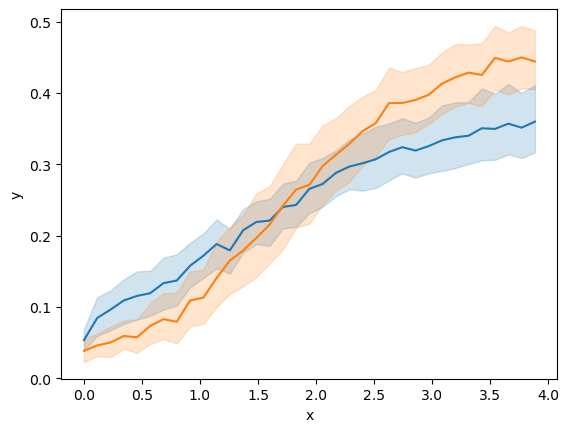

In [29]:
n_subs = 20
cont_df = pd.DataFrame()
ptsd_df = pd.DataFrame()

for i in range(n_subs):
    
    temp_c = add_sub(noise = .02, slope = 1.5, trials = 35)
    temp_c['sub'] = i
    cont_df = pd.concat([cont_df, temp_c])
    if i<20:
        temp_p = add_sub(noise = .02, slope = 4, trials = 35)
        temp_p['sub'] = i
        ptsd_df = pd.concat([ptsd_df, temp_p])
    
sub_idxC = list(cont_df['sub'])
sub_idxP = list(ptsd_df['sub'])


sns.lineplot(x='x',y='y',data=cont_df)
sns.lineplot(x='x',y='y',data=ptsd_df)

In [30]:
trace_hp_max2 = pl5_hyper(df_all, idx, group_sub_id)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b, mu_c, mu_g, a1, a2, d1, d2, a, b, c, d, g, eps]
INFO:pymc:NUTS: [mu_b, mu_c, mu_g, a1, a2, d1, d2, a, b, c, d, g, eps]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 626 seconds.
INFO:pymc:Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 626 seconds.


array([[<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'mu_c'}>,
        <AxesSubplot:title={'center':'mu_c'}>],
       [<AxesSubplot:title={'center':'a2'}>,
        <AxesSubplot:title={'center':'a2'}>],
       [<AxesSubplot:title={'center':'g'}>,
        <AxesSubplot:title={'center':'g'}>],
       [<AxesSubplot:title={'center':'mu_g'}>,
        <AxesSubplot:title={'center':'mu_g'}>],
       [<AxesSubplot:title={'center':'a1'}>,
        <AxesSubplot:title={'center':'a1'}>],
       [<AxesSubplot:title={'center':'d1'}>,
        <AxesSubplot:title={'center':'d1'}>],
       [<AxesSubplot:title={'center':'d2'}>,
        <AxesSubplot:title={'center':'d2'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'

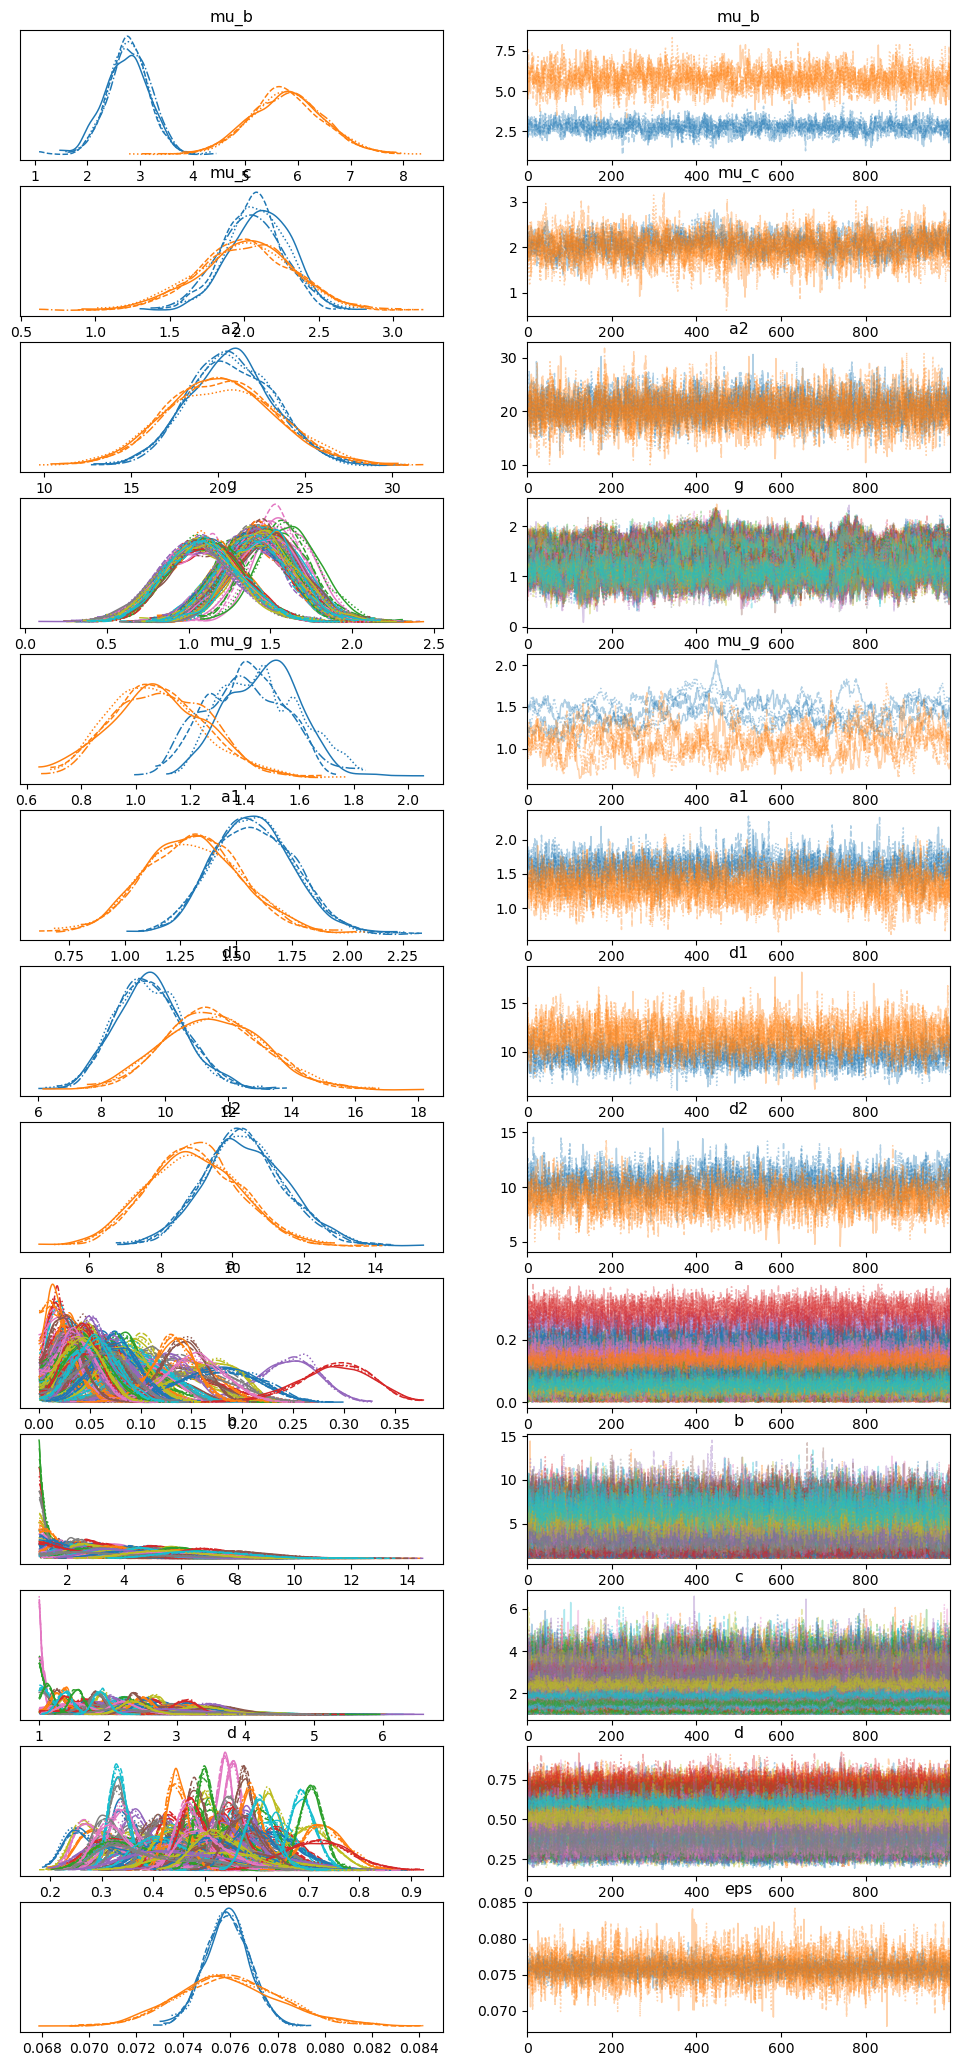

In [32]:
az.plot_trace(trace_hp_max2)